## Setup

In [269]:
import sys
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def load_data(dataset_name):
    # Read the data and create the dataframe.
    df = pd.DataFrame(pd.read_csv(dataset_name, encoding='utf-8', sep=",", skiprows = 1, header=None))

    # Specify column names.
    df.columns = ['day', 'isweekend', 'weekday', 'periodofday', 'nr_bookings_period', 'weather', 'calls_period']

    # Convert the 'timestamp' column to date format.
    df['day'] = pd.to_datetime(df['day'], errors="raise")

    df.drop('calls_period', axis=1, inplace=True)
    
    df.dropna(inplace=True)

    return df.sort_values('day')


In [270]:
df = load_data("data/VancouverFullPreprocessed.csv")

In [271]:
df.head()

,day,isweekend,weekday,periodofday,nr_bookings_period,weather
0,2017-09-07 00:00:00+00:00,False,Thu,1,235,36
1,2017-09-07 00:00:00+00:00,False,Thu,2,954,36
2,2017-09-07 00:00:00+00:00,False,Thu,3,702,36
3,2017-09-07 00:00:00+00:00,False,Thu,4,729,36
4,2017-09-07 00:00:00+00:00,False,Thu,5,1183,36


## Data Preparation

In [272]:
# Convert weather to an integer identifier.
df['weather'] = df['weather'].apply(lambda x: int(x))

# Convert timestamp to an integer identifier of the day.
df['day_int'] = df['day'].apply(lambda x: x.toordinal())

# Extract day of the week and hour of the day.
df['dayofweek'] = df['day'].apply(lambda x: x.isoweekday())
df['hourofday'] = df['day'].apply(lambda x: x.hour)
df.drop('day', axis=1, inplace=True)

In [273]:
df.head()

,isweekend,weekday,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
0,False,Thu,1,235,36,736579,4,0
1,False,Thu,2,954,36,736579,4,0
2,False,Thu,3,702,36,736579,4,0
3,False,Thu,4,729,36,736579,4,0
4,False,Thu,5,1183,36,736579,4,0


In [274]:
df.describe()

,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.0
mean,4.000000,828.612245,7.142857,736606.040816,4.183673,0.0
std,2.002922,331.296194,6.553424,16.222631,2.040116,0.0
min,1.000000,221.000000,3.000000,736579.000000,1.000000,0.0
25%,2.000000,593.500000,4.000000,736591.000000,2.000000,0.0
50%,4.000000,819.000000,4.000000,736608.000000,4.000000,0.0
75%,6.000000,1044.500000,10.000000,736620.000000,6.000000,0.0
max,7.000000,1650.000000,38.000000,736632.000000,7.000000,0.0


In [275]:
mean_booking_per_period = df.groupby('periodofday')['nr_bookings_period'].mean()
mean_booking_per_period

periodofday
1     340.612245
2     769.265306
3     763.959184
4     819.510204
5    1230.734694
6    1179.693878
7     696.510204
Name: nr_bookings_period, dtype: float64

In [276]:
# Fill out days and periods that do not appear in our data as
# having the average number of bookings for that period.
from datetime import date

min_day = int(min(list(df['day_int'])))
max_day = int(max(list(df['day_int'])))
days = set(range(min_day, max_day + 1))
days_with_obs = set(df['day_int'])
missing_days = days - days_with_obs
new_rows = []
for day in missing_days:
    for i in range(7):
        row_data = {'day_int': day, 'dayofweek': date.fromordinal(day).isoweekday(), 'hourofday': i, 'periodofday': i + 1, 'nr_bookings_period': mean_booking_per_period[i + 1], 'weekday': 'Mon', 'weather': 0}
        new_rows.append(row_data)

new_df = pd.DataFrame(new_rows, columns = ['day_int', 'dayofweek', 'hourofday', 'periodofday', 'weekday', 'weather', 'nr_bookings_period'])
df = df.append(new_df, ignore_index=True, sort=True)
df.sort_values(['day_int', 'hourofday', 'periodofday'], inplace=True, ascending=True)

In [277]:
df.describe()

,day_int,dayofweek,hourofday,nr_bookings_period,periodofday,weather
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,736605.500000,4.055556,0.277778,828.612245,4.000000,6.481481
std,15.606441,2.015743,1.062794,326.863783,2.002651,6.577102
min,736579.000000,1.000000,0.000000,221.000000,1.000000,0.000000
25%,736592.000000,2.000000,0.000000,622.500000,2.000000,3.000000
50%,736605.500000,4.000000,0.000000,808.000000,4.000000,4.000000
75%,736619.000000,6.000000,0.000000,1049.750000,6.000000,10.000000
max,736632.000000,7.000000,6.000000,1650.000000,7.000000,38.000000


In [278]:
# One-hot encode categorical columns.
def one_hot_column(df, column_name):
    dummies = pd.get_dummies(df[column_name]).values.tolist()
    df.drop(column_name, axis=1, inplace=True)
    df[column_name] = dummies
    return df

df = one_hot_column(df, 'dayofweek')
df = one_hot_column(df, 'periodofday')
df = one_hot_column(df, 'weather')

In [279]:
# Number of days.
print(len(set(df['day_int'])))

54


In [280]:
# Divide the dataset into train and test sets.
max_day = max(df['day_int'].tolist())
df_train = df[df['day_int'] <= max_day - 47]
df_test = df[df['day_int'] > max_day - 47]

In [281]:
df_train.head()

,day_int,hourofday,isweekend,nr_bookings_period,weekday,dayofweek,periodofday,weather
0,736579,0,False,235.0,Thu,"[0, 0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,736579,0,False,954.0,Thu,"[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,736579,0,False,702.0,Thu,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,736579,0,False,729.0,Thu,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,736579,0,False,1183.0,Thu,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [282]:
print(len(df_train), len(df_test))

49 329


In [283]:
df_train = df_train.drop(columns=['isweekend', 'weekday', 'day_int', 'hourofday'])
df_train.head()

,nr_bookings_period,dayofweek,periodofday,weather
0,235.0,"[0, 0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,954.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,702.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,729.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,1183.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [284]:
df_test = df_test.drop(columns=['isweekend', 'weekday', 'day_int', 'hourofday'])
df_test.head()

,nr_bookings_period,dayofweek,periodofday,weather
49,289.0,"[0, 0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
54,992.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
53,715.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
55,749.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
51,1324.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [285]:
print(len(df_train), len(df_test))

49 329


In [286]:
# WARNING: This was the previous implementation of the function that
# generates the data in the correct format for the models.
# However, the way I first implemented it, it was including the
# variable we wanted to predict in the set of features used for prediction.
# Below you will find a correct version of this function.
# I kept the wrong implementation here in case someone wants to check that
# it indeed produced the results I reported in the slides.
def to_sequence_wrong(df):
    x = []
    y = [] 
    observations = []
    for _, row in df.iterrows():
        observations.append([row['nr_bookings_period']] + row['dayofweek'] + row['periodofday'] + row['weather'])
    for j in range(len(observations)):
        window = [observations[j]]
        window = [x for x in window]
        x.append(window)
        y.append(window[0][0])
    return np.array(x), np.array(y)

In [287]:
def to_sequence(df):
    x = []
    y = [] 
    observations = []
    for _, row in df.iterrows():
        observations.append([row['nr_bookings_period']] + row['dayofweek'] + row['periodofday'] + row['weather'])
    for j in range(len(observations)):
        window = [observations[j]]
        y.append(window[0][0])
        window = [x[1:] for x in window]
        x.append(window)
        
    return np.array(x), np.array(y)


In [288]:
x_train, y_train = to_sequence(df_train)
x_test, y_test = to_sequence(df_test)

In [289]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (49, 1, 30)
Shape of test set: (329, 1, 30)


In [290]:
# Print a pair features (x_train) and corresponding number of bookings (y_train)
print(x_train[0], y_train[0])

[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]] 235.0


In [291]:
# Print a pair features (x_test) and corresponding number of bookings (y_test)
print(x_test[0], y_test[0])

[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] 289.0


In [292]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

x_train = x_train.reshape((x_train.shape[0], 30))
x_test = x_test.reshape((x_test.shape[0], 30))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (49, 1, 30)
Shape of test set: (329, 1, 30)
Shape of training set: (49, 30)
Shape of test set: (329, 30)


In [293]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Auto ARIMA model
import pmdarima as pm

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy
from collections import defaultdict

from sklearn.preprocessing import RobustScaler

def evaluate(x_train, x_test, y_train, y_test):
    # Instantiate the models
    linear_regression = LinearRegression(fit_intercept=False)
    elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)
    random_forest = RandomForestRegressor(n_estimators=20)
    extra_trees = ExtraTreesRegressor(n_estimators=20)
    # MARCO FIX: check for different hyperparams
    svr = SVR(C = 1000, gamma = 0.1, epsilon = 0.1)
    gradient_boosting = GradientBoostingRegressor(n_estimators=20)
    arima_train = np.array([[float(item[0])] for item in x_train])
    # MARCO FIX: not sure we want to use a Seasonal arima
    # MARCO FIX: in any case - which value for m? 7 (daily periodicity) or 49? (weekly periodicity)
    arima = pm.auto_arima([x for x in arima_train], start_p=0, start_q=0, max_p=2, max_q=2, m=7,
                             start_P=0, max_P=2, seasonal=True, d=0, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

    model_name_list = ['Linear Regression', 'ElasticNet Regression', 'Random Forest', 'Extra Trees', 'Gradient Boosted', 'SVR', 'ARIMA', 'Baseline']
    models_list = [linear_regression, elastic_net, random_forest, extra_trees, gradient_boosting, svr, arima]
    evaluation_results = {name:{'predictions':[], 'actual_values':[]} for name in model_name_list}
    

    
    # Train and predict with each model
    for i, row in enumerate(y_test):
        if i % 10 == 0:
            print("Evaluating row {}/{}".format(i + 1, len(y_test)))
        for j, model in enumerate(models_list):
            # Train the model and test it in the next row of the test set.
            if j == len(models_list) - 1: # The ARIMA model is tested in a different way.
                model = model.fit(x = [x for x in arima_train], y = y_train)
                yhat = model.predict(n_periods = 1)[0]
                # CHECK: why update if we are going to fit anyways?
                # model.update(y_test[i], max_iter = 1)
            else:
                model = model.fit(x_train, y_train)
                yhat = model.predict(x_test[i].reshape(1, -1))

            # Keep track of predictions versus actual values
            # Workaround to remove bogus predictions
            if(abs(yhat - y_test[i]) > 1000):
                yhat = y_test[i]

            evaluation_results[model_name_list[j]]['predictions'].append(yhat)
            evaluation_results[model_name_list[j]]['actual_values'].append(y_test[i])
            
        # Use as baseline not just the overall average, but rather the average for each time bin
        evaluation_results['Baseline']['predictions'].append(mean_booking_per_period[i % 7 + 1])
        evaluation_results['Baseline']['actual_values'].append(y_test[i])
        
        # Add current row to the training set.
        # Sliding window: remove oldest element
        x_train = np.vstack((x_train, x_test[i]))
        x_train = x_train[1:]
        y_train = np.append(y_train, y_test[i])
        y_train = y_train[1:]
        
        # The training set of the ARIMA model does not have all the features.
        arima_train = np.vstack((arima_train, [x_test[i][0]]))
        arima_train = arima_train[1:]
    
    return evaluation_results


In [294]:
results = evaluate(x_train, x_test, y_train, y_test)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 7); AIC=55.297, BIC=60.510, Fit time=0.151 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=77.049, BIC=80.524, Fit time=0.017 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=17.630, BIC=24.580, Fit time=0.098 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=30.268, BIC=37.219, Fit time=0.129 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=39.628, BIC=44.841, Fit time=0.020 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 7); AIC=12.212, BIC=20.900, Fit time=0.162 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=2.667, BIC=13.093, Fit time=0.424 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=48.305, BIC=56.993, Fit time=0.253 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=4.590, BIC=16.754, Fit time=0.479 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 1, 7); AIC=4.599, BIC=16.7

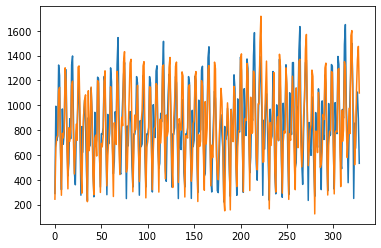

In [295]:
plt.plot(results['ARIMA']['actual_values'])
plt.plot(results['ARIMA']['predictions'])


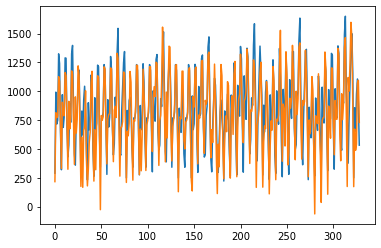

In [296]:
plt.plot(results['Linear Regression']['actual_values'])
plt.plot(results['Linear Regression']['predictions'])

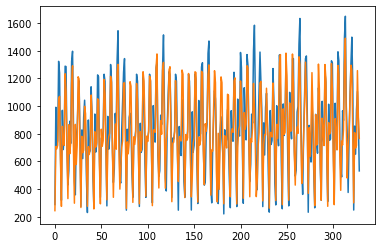

In [297]:
plt.plot(results['Random Forest']['actual_values'])
plt.plot(results['Random Forest']['predictions'])

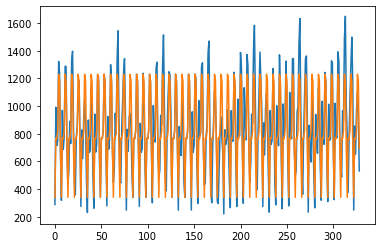

In [298]:
plt.plot(results['Baseline']['actual_values'])
plt.plot(results['Baseline']['predictions'])

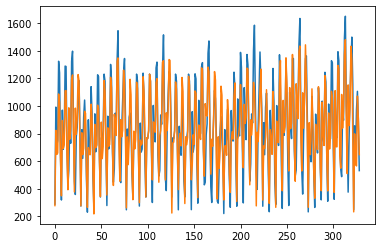

In [299]:
plt.plot(results['SVR']['actual_values'])
plt.plot(results['SVR']['predictions'])

In [300]:
for k, _ in results.items():
    model_name = k
    print("Model: ", model_name)
    yhat = np.array(results[model_name]['predictions'])
    y = np.array(results[model_name]['actual_values'])
    mape = []
    mae = []
    for i in range(len(results[model_name]['actual_values'])):
        mape.append(np.fabs((y[i] - yhat[i]) / y[i]) * 100)
        mae.append(np.fabs((y[i] - yhat[i])))
    print(np.min(mape), np.mean(mape), np.max(mape), np.std(mape))
    print()

Model:  Linear Regression
0.05811985656140519 21.715157550559663 197.49587651975156 26.61109980354075

Model:  ElasticNet Regression
0.0779356407279716 37.045782849659815 213.31449978107062 45.98505684979582

Model:  Random Forest
0.019744740001267972 15.29820836006165 171.51716767788193 19.36523554257875

Model:  Extra Trees
0.0 17.66357548092768 205.48986486486487 24.46491340257945

Model:  Gradient Boosted
0.401026238283163 19.92913121823035 157.52869966873507 23.303619132302003

Model:  SVR
0.008163575474061265 17.20241090419918 206.52930709875884 28.450192527233042

Model:  ARIMA
0.012869051977977566 21.80811388208468 263.2325068472346 26.50060320335202

Model:  Baseline
0.0 18.092554721645616 159.88692774407062 20.864458125559455



# Neural Network

In [301]:
x_train, y_train = to_sequence(df_train)
x_test, y_test = to_sequence(df_test)

In [302]:
print(x_train.shape, y_train.shape)

(49, 1, 30) (49,)


In [303]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

x_train = x_train.reshape((x_train.shape[0], 1, 30))
x_test = x_test.reshape((x_test.shape[0], 1, 30))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (49, 1, 30)
Shape of test set: (329, 1, 30)
Shape of training set: (49, 1, 30)
Shape of test set: (329, 1, 30)


In [304]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4


In [305]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def evaluate_neural_net(x_train, x_test, y_train, y_test):
    print('Build model...')
    model = Sequential()
    model.add(LSTM(64, dropout = 0.0, recurrent_dropout = 0.0, input_shape=(1, 30)))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience = 50, verbose = 0, mode='auto', restore_best_weights=True)
    
    yhats = []
    ys = []
    history = None
    # Train and predict with each model
    print('Training...')
    for i in range(len(y_test) - 1):
        if i % 10 == 0:
            print("Evaluating row {}/{}".format(i + 1, len(y_test) - 1))
        
        # Format the data for the neural network.
        x_val = np.array([[item] for item in x_test[i]], dtype=np.float32)
        y_val = np.array([y_test[i]], dtype=np.float32)
        
        # Build the model and predict the next row in the test set.
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), callbacks = [monitor], verbose = 0, epochs = 50)
        predictions = model.predict(x_test[i + 1].reshape(1, 1, 30))
        
        # Save results.
        yhats.append(predictions)
        ys.append(y_test[i + 1])
        
        # Add next row of the test set to the training set.
        x_train = np.vstack((x_train, x_val))
        y_train = np.append(y_train, y_val)

    return (yhats, ys, history, model)


In [306]:
yhats, ys, history, model = evaluate_neural_net(x_train, x_test, y_train, y_test)

Build model...
Training...
Evaluating row 1/328
Evaluating row 11/328
Evaluating row 21/328
Evaluating row 31/328
Evaluating row 41/328
Evaluating row 51/328
Evaluating row 61/328
Evaluating row 71/328
Evaluating row 81/328
Evaluating row 91/328
Evaluating row 101/328
Evaluating row 111/328
Evaluating row 121/328
Evaluating row 131/328
Evaluating row 141/328
Evaluating row 151/328
Evaluating row 161/328
Evaluating row 171/328
Evaluating row 181/328
Evaluating row 191/328
Evaluating row 201/328
Evaluating row 211/328
Evaluating row 221/328
Evaluating row 231/328
Evaluating row 241/328
Evaluating row 251/328
Evaluating row 261/328
Evaluating row 271/328
Evaluating row 281/328
Evaluating row 291/328
Evaluating row 301/328
Evaluating row 311/328
Evaluating row 321/328


In [307]:
mape = []
mae = []
for i in range(len(yhats)):
    mape.append(np.fabs((ys[i] - yhats[i]) / ys[i]) * 100)
    mae.append(np.fabs((ys[i] - yhats[i])))
print(np.min(mape), np.mean(mape), np.max(mape), np.std(mape))
print(np.mean(mae))

0.0029160362 13.527135 184.62085 19.437212
102.74533


In [308]:
def plot_pred(y_test, pred, figname):
    plt.figure()
    plt.plot(y_test, linestyle="-")
    plt.plot(pred, linestyle="--")
    plt.title('Predictions')
    plt.ylabel('Number of Bookings')
    plt.xlabel('Test Instance')
    plt.legend(['y_test', 'pred'], loc='best')
    plt.savefig(figname + ".pdf", format='pdf', dpi=150)
    plt.show()

In [309]:
yhats = [item[0] for item in yhats]

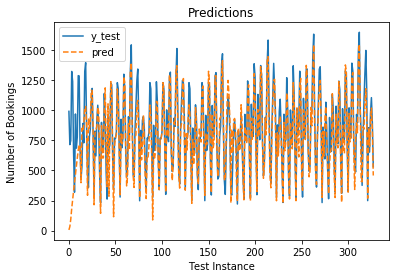

In [310]:
plot_pred(ys, yhats, "charts/NeuralNetPredictionDynamic")

In [311]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 24,585
Trainable params: 24,585
Non-trainable params: 0
_________________________________________________________________
